# Decision Trees for Predicting Dengue Fever: Subgroup Assessment

**Abstract:** A decision tree was trained on tabular medical data (age, temperature, WBC exam score, Plt exam score) to predict whether or not patients had dengue fever. Datasets were split according to various features to assess the model's predictive stability. Dengue fever is a serious illness that is initially not easily detectable, and initial symptoms tend to be similar to those of the flu. The advantage of using decision trees to predict the existence dengue fever in patients, as opposed to using other machine learning methods, is the method can be easily understood by doctors and is easily interpretable.

## Theory

### Decision Trees

Decision trees, or Classification and Regression Trees (CART), are widely-used machine learning tools that involve successively separating a set of samples into subsets or nodes of a tree. Typically, each node is separated into two subsequent nodes until there are no samples left to separate, or until a max-depth is reached for the tree. The nodes are split based upon a condition or characteristic that influences the dependent variable the most for samples in that node. In training, the most influential conditions are determined for each node when the tree is constructed, thereby grouping similar samples together into nodes, with similarity increasing with each split, (i.e., with increasing depth of the tree). Each node is classified based upon the most common value for the dependent variable in that node, thereby giving the nodes predictive power over the samples grouped into them. After the tree is constructed, the conditions that were used to split the nodes of the training set can be applied to similar datasets to group similar samples together, after which predictions can be made for samples based upon their nodes.

Note that while sample similarity for nodes of the tree increase as the depth of the tree increases, a tree that is too deep will overfit and describe conditions specific only to the training set. Thus, controlling the max-depth of the tree is a technique used to prevent overfitting, thereby forcing the tree to model more general trends inherent in the data.

### Subgroups

#### n-Fold Cross Validation: Training Multiple Models

In n-fold cross validation, the overall dataset is split into equal parts for the purpose of training multiple models, such that all of the data is used at least once in a validation set. The confusion matrices (true negatives, false positives, false negatives, true positives) for each model are then added together to calculate the overall metrics of the model.

For this experiment, 5-fold cross validation was performed. The dataset was split into five equal subsets (each 20% of original dataset). The subsets were grouped into five validation sets (20% of original dataset) and five training sets (80% of original dataset, i.e., original dataset minus validation set). Five logistic regression models were trained and then assessed with corresponding validation sets. The resulting five confusion matrices were summed, producing an overall confusion matrix that would be used to calculate overall metrics.

#### Validation Subgroup Analysis

The validation datasets of each model were split into multiple subgroups based on various features, *(Age, Gender, Epidemic periods, Body Temp, White Blood Cells, Platelet, Comorbidities, coming to ER)*, to assess stability of the model accross datasets. The subgroup confusion matrices were summed across multiple models, resulting in overall confusion matrices for each subgroup. Confusion matrices were then used to calculate overall metrics for each subgroup.

## Setup


This notebook was originally written with the following versions:

    python 3.7.4
    scikit-learn 0.20.4
    pandas 0.25.0
    numpy 1.16.4
    matplotlib 3.1.0
    scipy 1.3.1
    

In [1]:
# Check your versions
!python --version;
!pip freeze | grep scikit-learn;
!pip freeze | grep pandas;
!pip freeze | grep numpy;
!pip freeze | grep matplotlib;
!pip freeze | grep scipy;
!pip freeze | grep graphviz;
!pip freeze | grep pydotplus;

Python 3.7.4
scikit-learn==0.20.4
pandas==0.25.0
msgpack-numpy==0.4.3.2
numpy==1.16.4
numpydoc==0.9.1
matplotlib==3.1.0
scipy==1.3.1
graphviz==0.10.1
pydotplus==2.0.2


##### Prepare Notebook

In [2]:
# Jupyter Notebook Magic

%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Import Modules

import datetime
from pathlib import Path
import unittest

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics

from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydotplus

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import interp

# My Own Modules
from pyfiles.autometrics import show_metrics, subgroup_analysis, conf_and_auc
import pyfiles.autometrics
# import pyfiles.df_converter

# Data Information

filename = 'patient_year_vital_lab_exam_add-on_death_outcome_comorbidity_TCIC_dengue_suspected_bmi_ER_label_missing_mask.csv'
path = Path('../mydata')

In [3]:
# View all CSV column names

# df = pd.read_csv(path/filename, low_memory=False)
# "', '".join(df.columns.tolist())

## Parameters

In [4]:
splits = 5 # number of folds for cross validation
recalls = [0.85,0.90,0.95] # sensitivities used for calculating results


# Imported columns from CSV
desired_cols = ['age','sex','Temp','exam_WBC','exam_Plt', 'Opd_Visit_Date',
                'ER', 'Heart Disease', 'CVA', 'CKD', 'Severe Liver Disease', 
                'DM', 'Hypertension', 'Cancer without Metastasis', 'Cancer with Metastasis',
                'lab_result']

# Features used for training + dependent variable
train_cols = ['age','Temp','exam_WBC','exam_Plt','lab_result']


# Features used for creating validation subgroups (includes features from train_cols)
subgroup_cols = ['age','sex','Temp','exam_WBC','exam_Plt', 'week',
                'ER', 'Heart Disease', 'CVA', 'CKD', 'Severe Liver Disease', 
                'DM', 'Hypertension', 'Cancer without Metastasis', 'Cancer with Metastasis',
                'lab_result']

dep_var = 'lab_result'

# Columns to be dropped after creating validation subgroups
drop_cols = list(set(subgroup_cols) - set(train_cols))

## Data Preparation

### Convert CSV to Dataframe –> Randomize Dataframe –> Convert Categorical Values to Numeric Ones

In [5]:
# Read CSV with desired columns

# desired_cols defined in Parameters section
df = pd.read_csv(path/filename, usecols=desired_cols)


# Randomize data
df = df.iloc[np.random.permutation(len(df))]


# Convert Opd_Visit_Date to week of year format

if 'week' not in df.columns:
    week_numbers = [datetime.datetime.strptime(d, "%Y/%m/%d").isocalendar()[1] for d in df['Opd_Visit_Date']]
    df.insert(0, 'week', week_numbers)
    
if 'Opd_Visit_Date' in df.columns:
    df.drop(columns=['Opd_Visit_Date'],inplace=True)
    
    
# Convert 男 and 女 to 0 and 1 in column 'sex'

df_male_indx = df[df['sex']=='男']
df_female_indx = df[df['sex']=='女']

for i in df_male_indx.index.tolist():
    df.at[int(i),'sex'] = 0
    
for i in df_female_indx.index.tolist():
    df.at[int(i),'sex'] = 1

print('Size:',len(df))    
df.head()

Size: 6470


week sex  age  Temp  exam_Plt  exam_WBC    CKD     DM    CVA  \
4602    40   1   52  38.8     105.0       5.9   True  False  False   
167     33   1   36  38.7     101.0       2.9  False  False  False   
4519    40   0   32  39.6     181.0       5.7  False   True  False   
2701    38   0   21  38.9     176.0       3.5   True   True  False   
1423    36   0   31  38.4     315.0      12.7  False  False  False   

      Hypertension  Heart Disease  Cancer without Metastasis  \
4602         False          False                      False   
167          False          False                      False   
4519          True           True                      False   
2701          True          False                      False   
1423         False          False                      False   

      Cancer with Metastasis  Severe Liver Disease  lab_result     ER  
4602                   False                 False        True   True  
167                    False                 False        True  False  
4519                   False                 False        True   True  
2701                   False                 False        True   True  
1423                   False                 False        True   True

### Separate Dataframe into Subsets

In [6]:
dataframe = df

# Equal length subsets of original dataframe
len_df = len(dataframe)
cut_indices = [int(i*(1/splits)*len_df) for i in range(0,splits+1)]
cut_indices = zip(cut_indices[:-1], cut_indices[1:])
subsets = [dataframe[i:j] for i,j in cut_indices]

# print sizes
print('Dataframe', ' Sizes')
print('-'*28)
for i in range(splits):
    print(f'Subset {i+1}:  {len(subsets[i])} ({100*len(subsets[i])/len(dataframe):0.1f}%)')
print('-'*28)
print(f'Original:  {len(dataframe)} ({100*len(dataframe)/len(dataframe):0.1f}%)')

Dataframe  Sizes
----------------------------
Subset 1:  1294 (20.0%)
Subset 2:  1294 (20.0%)
Subset 3:  1294 (20.0%)
Subset 4:  1294 (20.0%)
Subset 5:  1294 (20.0%)
----------------------------
Original:  6470 (100.0%)


### Build Training Sets from Subsets

In [7]:
trains = [pd.concat(subsets[1:], axis=0)]
for n in range(1,splits):
    trains += [pd.concat(subsets[:n]+subsets[n+1:], axis=0)] 

len(trains)


5

### Build Validation Subgroups

In [8]:
# Separate Dataframe into Subgroups

frames = [] # temporarily stores dataframes

for modelnum in range(1,splits+1):

    dataframe = subsets[modelnum-1] # validation set

    # age
    df_age_under_18 = dataframe[dataframe['age']<18]
    df_age_18_to_65 = dataframe[(dataframe['age']>=18) & (dataframe['age']<65)]
    df_age_over_eq_65 = dataframe[dataframe['age']>=65]

    # sex
    df_female = dataframe[dataframe['sex']==1]
    df_male = dataframe[dataframe['sex']==0]

    # week
    df_wks_35 = dataframe[dataframe['week']<=35]
    df_wks_35_to_40 = dataframe[(dataframe['week']>35) & (dataframe['week']<=40)]
    df_wks_over_40 = dataframe[dataframe['week']>40]

    # Temp
    df_temp_over_38 = dataframe[dataframe['Temp']>38]
    df_temp_under_eq_38 = dataframe[dataframe['Temp']<=38]

    # exam_WBC
    df_wbc_low = dataframe[dataframe['exam_WBC']<3.2]
    df_wbc_normal = dataframe[(dataframe['exam_WBC']>=3.2) & (dataframe['exam_WBC']<10)]
    df_wbc_high = dataframe[dataframe['exam_WBC']>10]

    # exam_Plt
    df_plt_low = dataframe[dataframe['exam_Plt']<100]
    df_plt_high = dataframe[dataframe['exam_Plt']>=100]

    # Comorbidities
    df_heart_disease = dataframe[dataframe['Heart Disease']==True]
    df_cva = dataframe[dataframe['CVA']==True]
    df_ckd = dataframe[dataframe['CKD']==True]
    df_liver = dataframe[dataframe['Severe Liver Disease']==True]
    df_dm = dataframe[dataframe['DM']==True]
    df_hypertension = dataframe[dataframe['Hypertension']==True]


    df_cancer1 = dataframe[(dataframe['Cancer with Metastasis']==True)]
    df_cancer2 = dataframe[(dataframe['Cancer without Metastasis']==True)]
    df_cancer = pd.concat([df_cancer1, df_cancer2], axis=0)

    df_er = dataframe[dataframe['ER']==True]

    frame = [df_age_under_18, df_age_18_to_65, df_age_over_eq_65, df_female, df_male, df_wks_35, df_wks_35_to_40, 
          df_wks_over_40, df_temp_over_38, df_temp_under_eq_38, df_wbc_low, df_wbc_normal, df_wbc_high, 
          df_plt_low, df_plt_high, df_heart_disease, df_cva, df_ckd, df_liver, df_dm, df_hypertension, 
          df_cancer, df_er]

    dfs_names = ['df_age_under_18', 'df_age_18_to_65', 'df_age_over_eq_65', 'df_female', 'df_male', 'df_wks_35', 'df_wks_35_to_40', 
          'df_wks_over_40', 'df_temp_over_38', 'df_temp_under_eq_38', 'df_wbc_low', 'df_wbc_normal', 'df_wbc_high', 
          'df_plt_low', 'df_plt_high', 'df_heart_disease', 'df_cva', 'df_ckd', 'df_liver', 'df_dm', 'df_hypertension', 
          'df_cancer', 'df_er']

    dfs = frame # because of older code... (technical debt)

    # Display Subgroup Sizes

    print("Dataframes (Model "+str(modelnum)+')'," "*(20-len('dataframes (Model n)')),"| Length", ' ',"| Percent Length")
    print("-"*50)
    length = 0
    for i in range(len(dfs)):
        print(dfs_names[i],' '*(20-len(dfs_names[i])),'|',len(dfs[i]),' '*(7-len(str(len(dfs[i])))),f'| {100*len(dfs[i])/len(dataframe):0.2f}%')
        length += len(dfs[i])
    print('-'*42)
    print('valid_df '+str(modelnum),' '*(20-len('valid_df 1')), '|', len(dataframe),' '*2 ,f' | 100%') 
    print('\n'*2)

    frames += [frame]
    
# RESET DFS

dfs = frames


Dataframes (Model 1)  | Length   | Percent Length
--------------------------------------------------
df_age_under_18       | 105      | 8.11%
df_age_18_to_65       | 865      | 66.85%
df_age_over_eq_65     | 324      | 25.04%
df_female             | 673      | 52.01%
df_male               | 621      | 47.99%
df_wks_35             | 221      | 17.08%
df_wks_35_to_40       | 775      | 59.89%
df_wks_over_40        | 298      | 23.03%
df_temp_over_38       | 688      | 53.17%
df_temp_under_eq_38   | 604      | 46.68%
df_wbc_low            | 229      | 17.70%
df_wbc_normal         | 780      | 60.28%
df_wbc_high           | 193      | 14.91%
df_plt_low            | 257      | 19.86%
df_plt_high           | 971      | 75.04%
df_heart_disease      | 131      | 10.12%
df_cva                | 71       | 5.49%
df_ckd                | 270      | 20.87%
df_liver              | 121      | 9.35%
df_dm                 | 220      | 17.00%
df_hypertension       | 258      | 19.94%
df_cancer           

In [9]:
# show a random subgroup in dfs[0]
ri = np.random.randint(low=0,high=len(dfs[0]))
print(dfs_names[ri])
dfs[0][ri].head()

df_wbc_low


week sex  age  Temp  exam_Plt  exam_WBC    CKD     DM    CVA  \
167     33   1   36  38.7     101.0       2.9  False  False  False   
189     33   0   35  37.2     145.0       2.3  False  False  False   
4083    39   0   53  38.3      49.0       1.6  False  False  False   
424     34   1   40  37.7     118.0       1.8  False  False  False   
2475    37   0   32  38.8     197.0       3.0  False  False  False   

      Hypertension  Heart Disease  Cancer without Metastasis  \
167          False          False                      False   
189           True          False                      False   
4083         False           True                      False   
424          False          False                      False   
2475          True          False                      False   

      Cancer with Metastasis  Severe Liver Disease  lab_result     ER  
167                    False                 False        True  False  
189                    False                 False       False   True  
4083                   False                 False       False   True  
424                    False                 False        True   True  
2475                   False                 False        True   True

### Remove Unused Features for All Models

In [10]:
# drop_cols defined in Parameters section

for model_indx in range(len(dfs)):
    dataframes = dfs[model_indx]
    train_df = trains[model_indx]
    valid_df = subsets[model_indx]
    
    
    # Remove columns of unused features in validation subgroups
    for i in range(len(dataframes)):
        if drop_cols[0] in dataframes[i].columns:
            dataframes[i].drop(columns=drop_cols,inplace=True)

    # Remove columns of unused features in training dataset
    if drop_cols[0] in train_df.columns:
        train_df.drop(columns=drop_cols,inplace=True)

    # Remove columns of unused features in full validation dataset
    if drop_cols[0] in valid_df.columns:
        valid_df.drop(columns=drop_cols,inplace=True)

    print("(ignore the pandas warning)")
        

(ignore the pandas warning)
(ignore the pandas warning)
(ignore the pandas warning)
(ignore the pandas warning)
(ignore the pandas warning)


/home/gilbert/anaconda3/envs/econda/lib/python3.7/site-packages/pandas/core/frame.py:4097: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [11]:
# show a random subgroup in dfs[0]
# ri = np.random.randint(low=0,high=len(dfs1))
print(dfs_names[ri])
dfs[0][ri].head()

df_wbc_low


age  Temp  exam_Plt  exam_WBC  lab_result
167    36  38.7     101.0       2.9        True
189    35  37.2     145.0       2.3       False
4083   53  38.3      49.0       1.6       False
424    40  37.7     118.0       1.8        True
2475   32  38.8     197.0       3.0        True

### Remove NaN Values for All Models

The logistic regression model cannot do anything with NaN inputs. Two options for dealing with this are drop all data with NaN values, or to transform all NaN inputs into the median values of their corresponding columns.

In [12]:
for model_indx in range(len(dfs)):
    dataframes = dfs[model_indx]
    train_df = trains[model_indx]
    valid_df = subsets[model_indx]

    # Option A: Drop NaNs

    # Remove NaN values in Validation Subgroups
    print('-'*60)
    print("Dataframes (Model "+str(model_indx+1)+')'," "*(20-len('dataframes (model n)')),"| Before","| After   |", 'NaNs Removed')
    print("-"*60)
    for i in range(len(dataframes)):
        before = len(dataframes[i])
        dataframes[i].dropna(how='any',inplace=True)
        after = len(dataframes[i])
        print(dfs_names[i],' '*(20-len(dfs_names[i])),'|',before,' '*(5-len(str(before))),'|   ',after,' '*(3-len(str(after))),'|    ', before-after)

    # Remove NaN values in Training Dataset
    before = len(train_df)
    train_df.dropna(how='any',inplace=True)
    after = len(train_df)
    print('train_df',' '*(20-len('train_df')),'|',before,' '*(5-len(str(before))),'|  ',after,' '*(3-len(str(after))),'|    ', before-after)

    # Remove NaN values in Full Validation Dataset
    before = len(valid_df)
    valid_df.dropna(how='any',inplace=True)
    after = len(valid_df)
    print('valid_df',' '*(20-len('valid_df')),'|',before,' '*(5-len(str(before))),'|  ',after,' '*(3-len(str(after))),'|    ', before-after)

    print('-'*60)
    print('\n'*2)

    # Option B: Convert NaNs to median values

    # for i in range(len(dataframes)):
    #     dataframes[i] = NaN_converter(dataframes[i])

    # train_df = NaN_converter(train_df)
    # valid_df = NaN_converter(valid_df)

------------------------------------------------------------
Dataframes (Model 1)  | Before | After   | NaNs Removed
------------------------------------------------------------
df_age_under_18       | 105    |    86   |     19
df_age_18_to_65       | 865    |    806  |     59
df_age_over_eq_65     | 324    |    313  |     11
df_female             | 673    |    623  |     50
df_male               | 621    |    582  |     39
df_wks_35             | 221    |    209  |     12
df_wks_35_to_40       | 775    |    722  |     53
df_wks_over_40        | 298    |    274  |     24
df_temp_over_38       | 688    |    661  |     27
df_temp_under_eq_38   | 604    |    544  |     60
df_wbc_low            | 229    |    229  |     0
df_wbc_normal         | 780    |    777  |     3
df_wbc_high           | 193    |    192  |     1
df_plt_low            | 257    |    246  |     11
df_plt_high           | 971    |    959  |     12
df_heart_disease      | 131    |    121  |     10
df_cva                | 7

/home/gilbert/anaconda3/envs/econda/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/gilbert/anaconda3/envs/econda/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


              | 112    |    104  |     8
df_dm                 | 220    |    200  |     20
df_hypertension       | 241    |    225  |     16
df_cancer             | 218    |    204  |     14
df_er                 | 1042   |    965  |     77
train_df              | 5176   |   4790  |     386
valid_df              | 1294   |   1205  |     89
------------------------------------------------------------





## Training

In [13]:
model_classifiers = []
model_preds = []
model_scores = []
model_valid_Ys = []
imgs = []
for model_indx in range(len(dfs)):
    train_df = trains[model_indx]
    valid_df = subsets[model_indx]

    # MORE DATA PREPARATION
    
    # Separate inputs (X) from outputs (Y)
    train_X = train_df.loc[:,train_df.columns != 'lab_result']
    train_Y = train_df.loc[:,train_df.columns == 'lab_result']
    valid_X = valid_df.loc[:,valid_df.columns != 'lab_result']
    valid_Y = valid_df.loc[:,valid_df.columns == 'lab_result']

    # Convert to numpy arrays
    train_X = train_X.to_numpy('float64')
    train_Y = train_Y.to_numpy('float64').flatten()
    valid_X = valid_X.to_numpy('float64')
    valid_Y = valid_Y.to_numpy('float64').flatten()
    
    model_valid_Ys += [valid_Y] # save for later
    
    # TRAIN WITH CHOSEN SOLVER
    
#     solver = 'lbfgs'

    print(f'Model {model_indx+1}')
#     print("Solver: ", solver)

#     clf = LogisticRegression(solver=solver,
#                                     penalty='l2', class_weight={0:1, 1:1},
#                                     max_iter=400)

    clf = DecisionTreeRegressor(max_depth=5)
    
    clf.fit(train_X, train_Y)
#     Y_pred = clf.predict_proba(valid_X)[:,1]
    Y_pred = clf.predict(valid_X)
#     score = clf.score(valid_X,valid_Y)
    score = 1 - metrics.mean_squared_error(valid_Y, Y_pred)
    print("Validation Score: {}\n".format(score))
    
    
    # create image
    dot_data = StringIO()
    export_graphviz(clf, out_file=dot_data,  
                    filled=True, rounded=True,
                    special_characters=True, class_names=[dep_var], feature_names=train_cols[:-1],
                   max_depth=None)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
    img = Image(graph.create_png())


    # save the image file
    path = Path('../mydata/myoutput')
    file = f'tree_{model_indx+1}.png'

    with open(path/file, "wb") as png:
        png.write(img.data)

    imgs += [img]
    
    model_classifiers += [clf]
    model_preds += [Y_pred]

    model_scores += [score]

Model 1
Validation Score: 0.7975841214593551

Model 2
Validation Score: 0.8115467767630353

Model 3
Validation Score: 0.7957173874352105

Model 4
Validation Score: 0.8027573031625732

Model 5
Validation Score: 0.806444387745962




Model 1


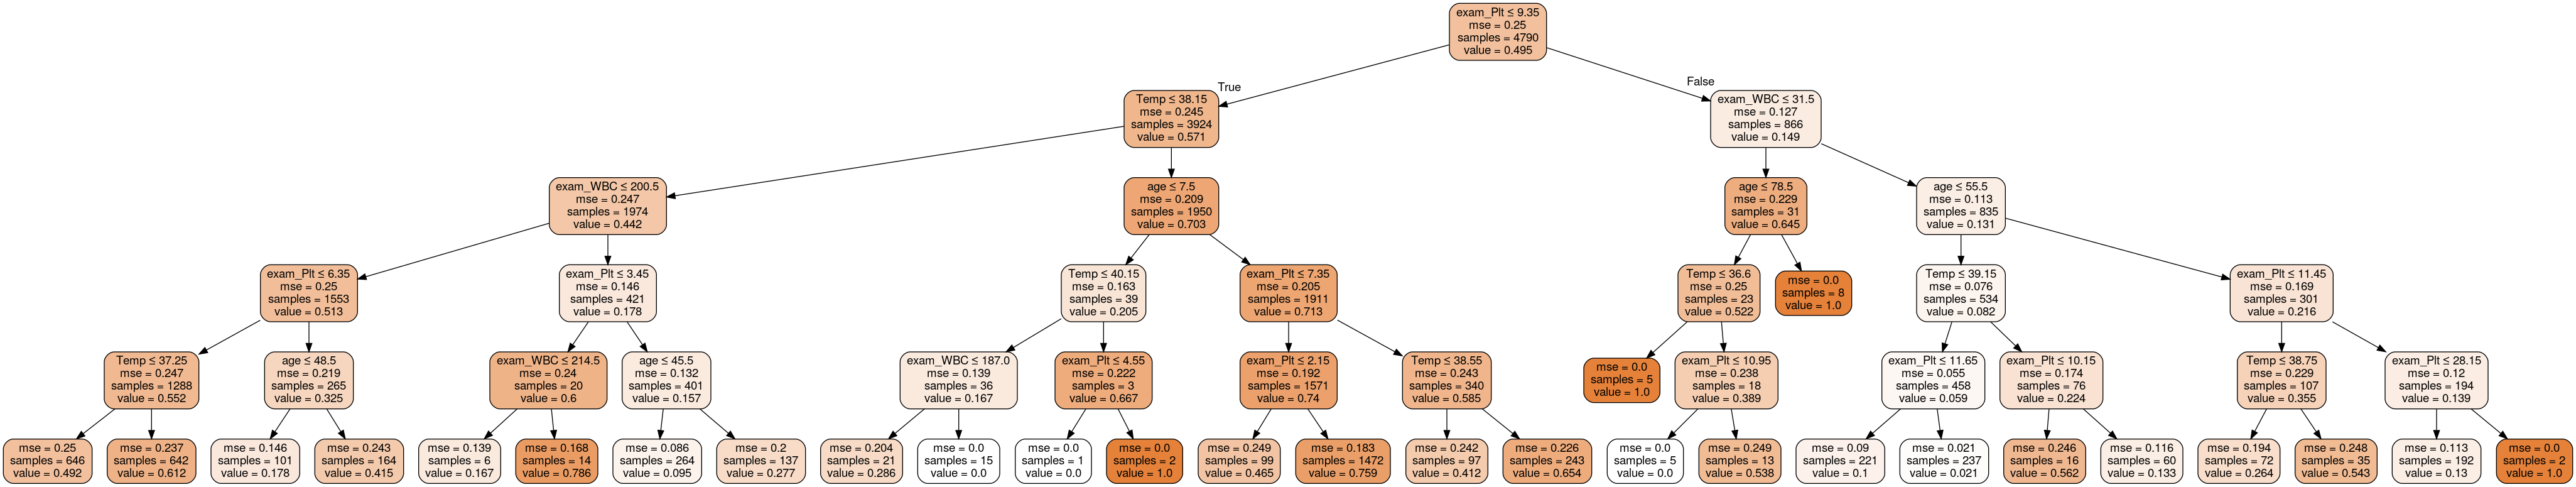



Model 2


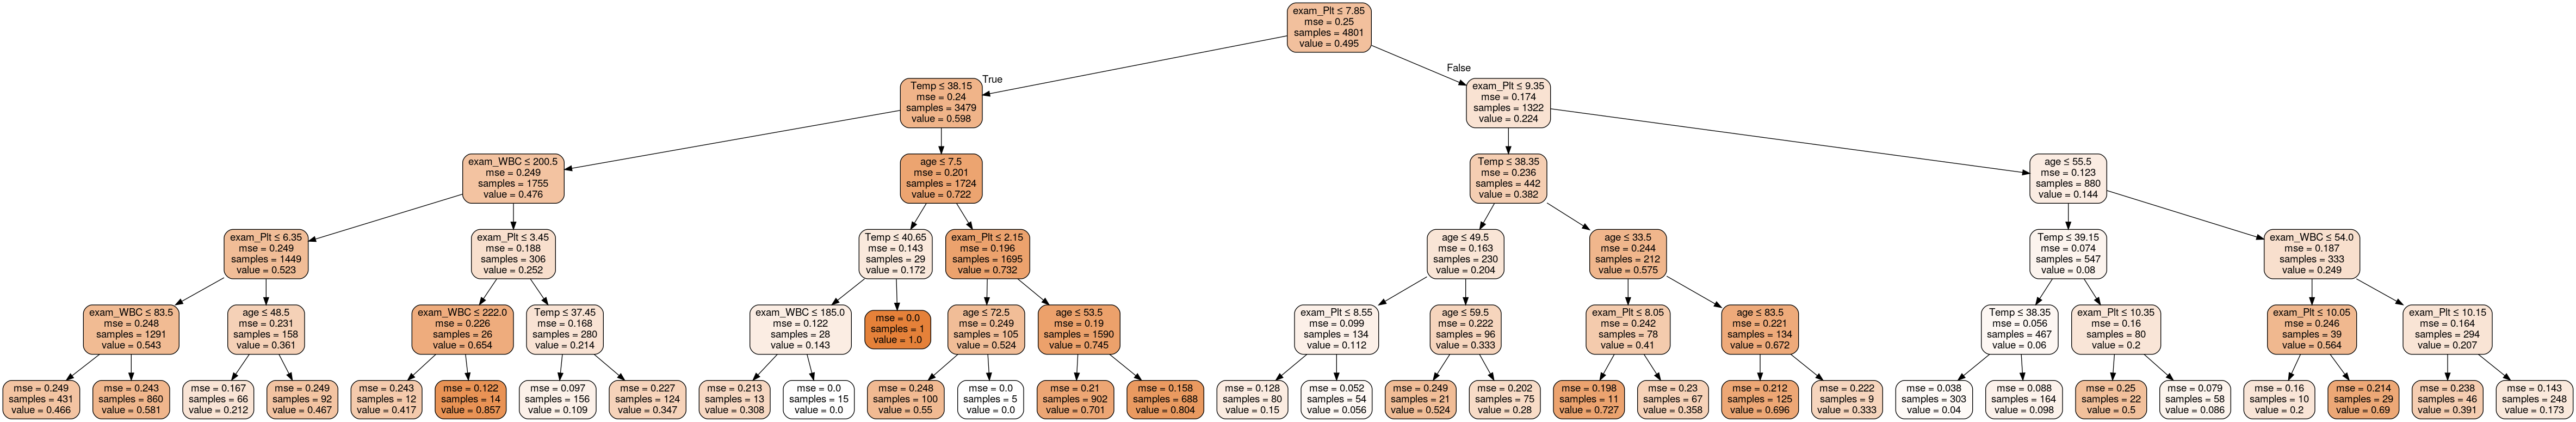



Model 3


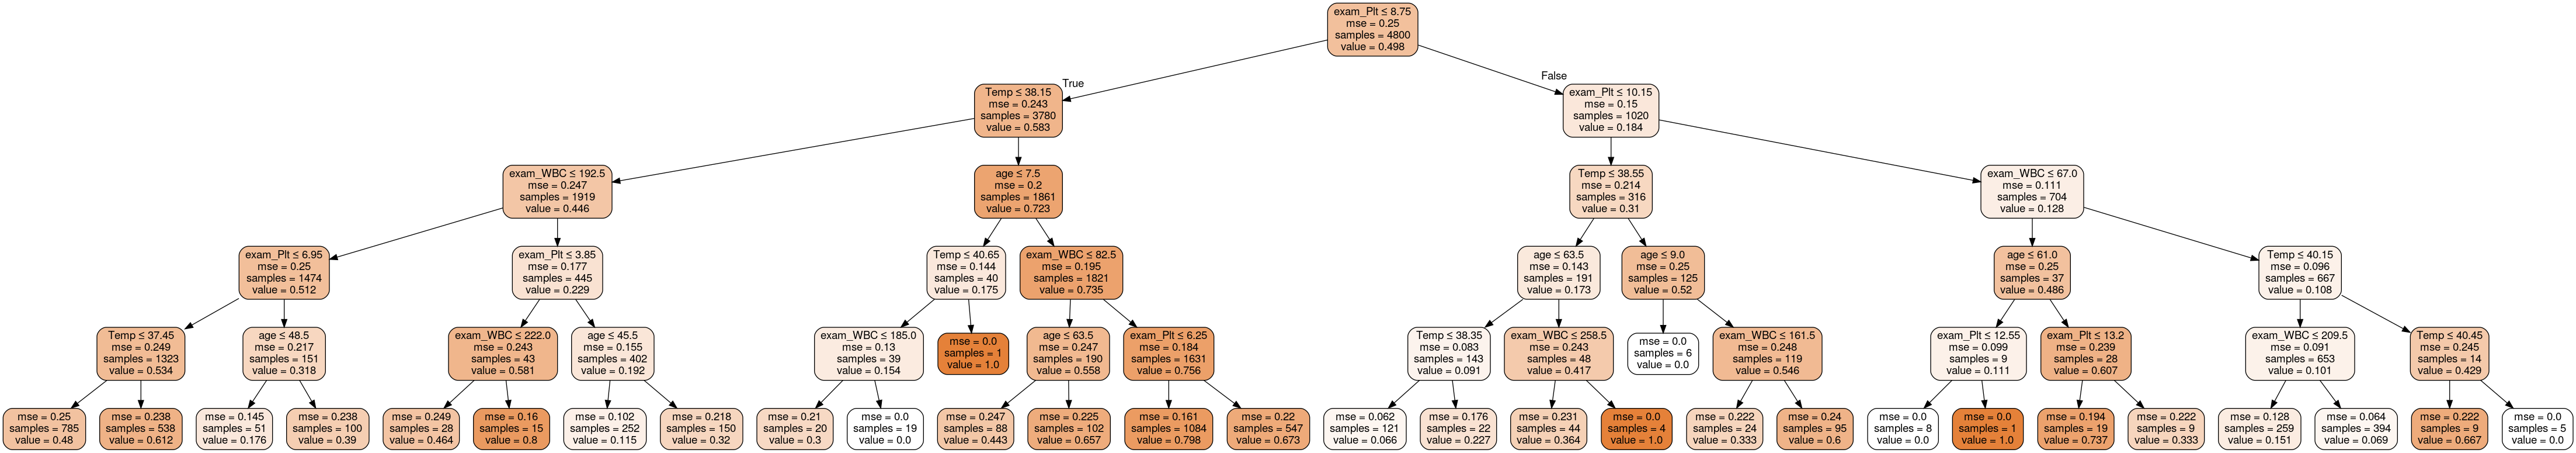



Model 4


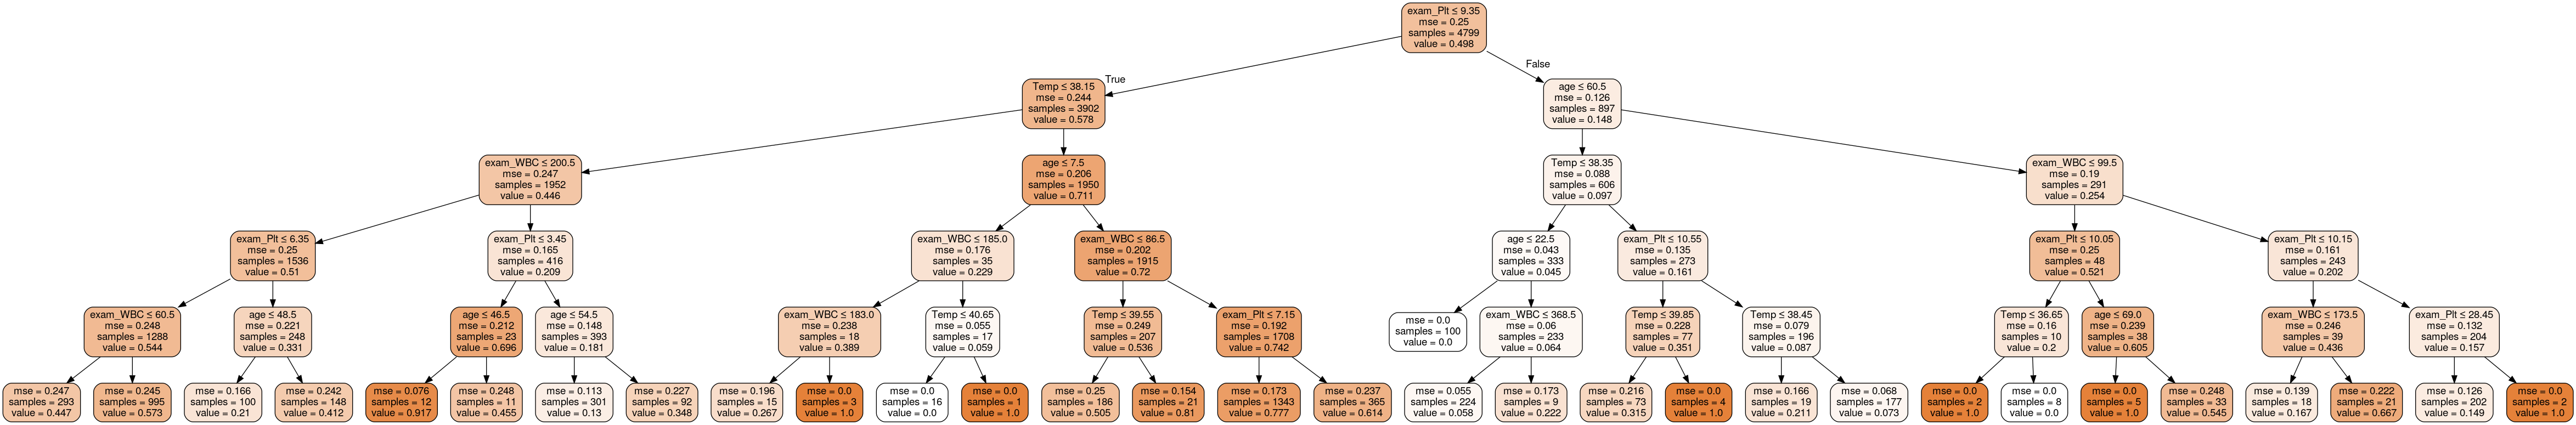



Model 5


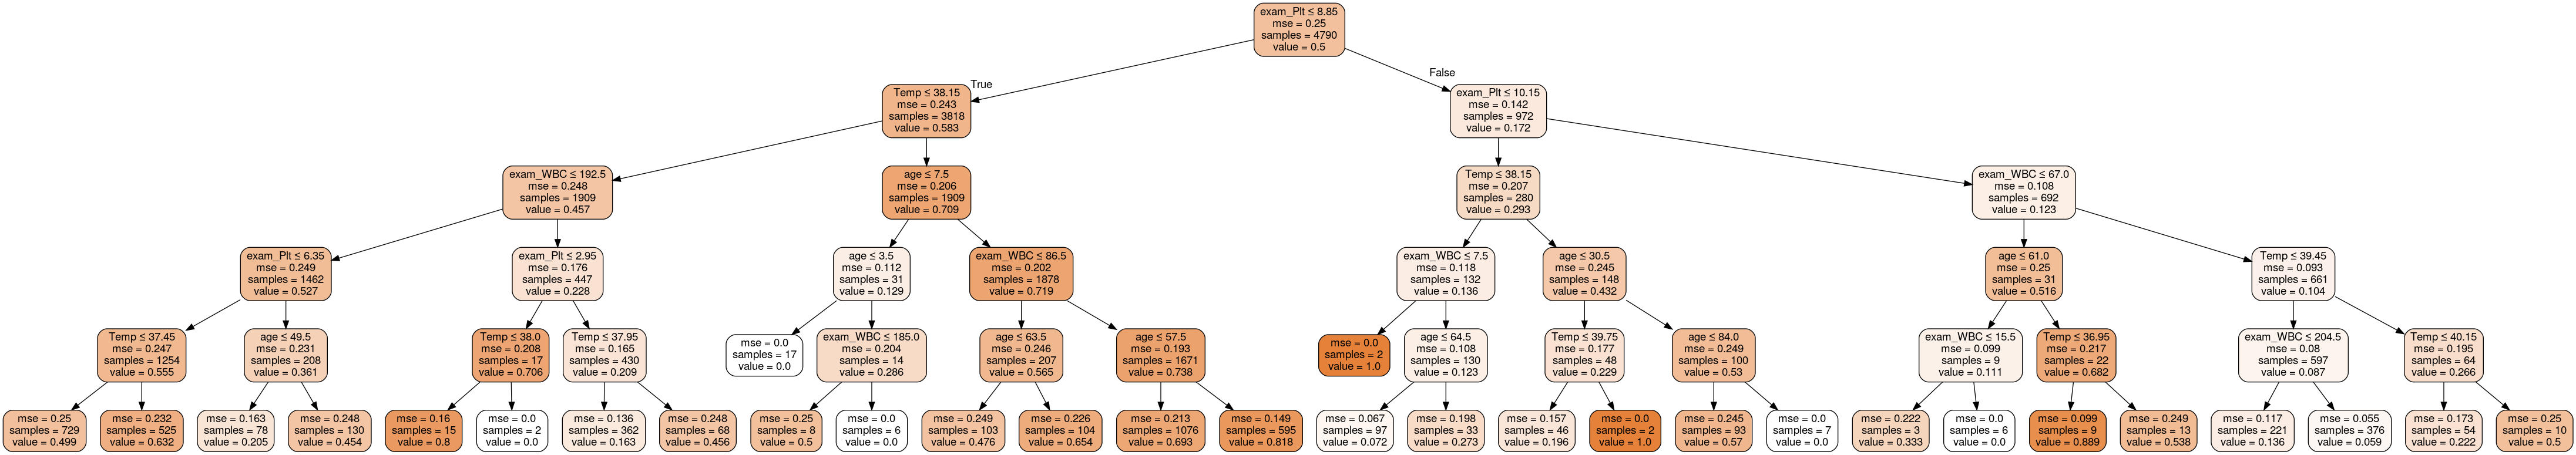

In [14]:
for i in range(len(imgs)):
    print('\nModel',i+1)
    display(imgs[i])
    print('')

## Overall Metrics

In [15]:
# Overall Results

# recalls defined in Parameters section

# For each recall
    # Get results for overall validation set for each model
    # Sum confusion matrices across models
    # return metrics for overall results of all models

for rec in recalls:
    confs = []
    for model_indx in range(len(dfs)):
        result_prob = model_preds[model_indx]
        label = model_valid_Ys[model_indx]
        recall = rec

        conf, roc_auc = conf_and_auc(label, result_prob, recall)

        confs += [conf]

    conf = sum(confs)
    results = pyfiles.autometrics.return_metrics(conf,roc_auc)
    result_names = ['roc_auc', 'PPV', 'NPV', 'F1', 'accuracy', 'sensitivity', 'specificity', 'odds_ratio', 'TN', 'FP', 'FN', 'TP', 'length']

    meh = list(zip(result_names, results))
    print('OVERALL RESULTS',' '*5,f'(Recall: {recall})')
    print('-'*35)
    for i in range(len(meh)):
        print(f'{meh[i][0]}', ' '*(15-len(str(result_names[i]))) ,f'{meh[i][1]}')
    print('\n'*2)


OVERALL RESULTS       (Recall: 0.85)
-----------------------------------
roc_auc          0.7719678883148532
PPV              0.6449494949494949
NPV              0.7906633906633906
F1               0.7360230547550433
accuracy         0.6944120100083403
sensitivity      0.8570469798657718
specificity      0.5336650082918739
odds_ratio       6.860914658171886
TN               1609
FP               1406
FN               426
TP               2554
length           5995



OVERALL RESULTS       (Recall: 0.9)
-----------------------------------
roc_auc          0.7719678883148532
PPV              0.6321487408802071
NPV              0.8316151202749141
F1               0.7431179969567022
accuracy         0.6902418682235196
sensitivity      0.9013422818791946
specificity      0.481592039800995
odds_ratio       8.487236737305286
TN               1452
FP               1563
FN               294
TP               2686
length           5995



OVERALL RESULTS       (Recall: 0.95)
---------------------

#### ROC Curves for Each Model

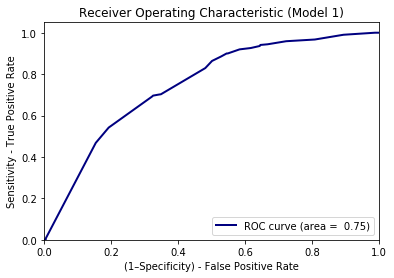

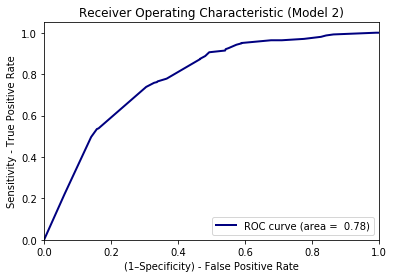

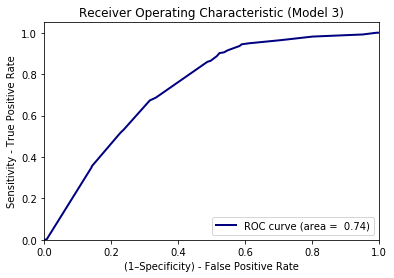

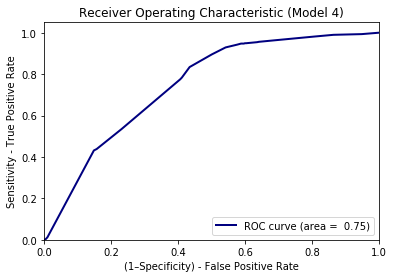

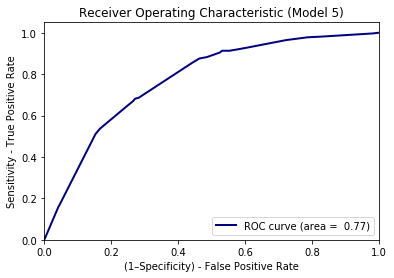

In [16]:
# show ROC curve for each model

tprs = []
fprs = []
tprs_interp = []
base_fpr = np.linspace(0, 1, 101)

for model_indx in range(len(dfs)):
    result_prob = model_preds[model_indx]
    label = model_valid_Ys[model_indx]

    score = np.array([result_prob[j] for j in range(result_prob.shape[0])])
    fpr, tpr, thresholds = metrics.roc_curve(label, score, pos_label=1)
    roc_auc = metrics.auc(fpr, tpr)

    # Plot ROC Curve for Each Model
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='navy',
             lw=lw, label=f'ROC curve (area = {roc_auc: 0.2f})')
    # plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('(1–Specificity) - False Positive Rate')
    plt.ylabel('Sensitivity - True Positive Rate')
    plt.title(f'Receiver Operating Characteristic (Model {model_indx+1})')
    plt.legend(loc="lower right")
    plt.show()
    
    # Store fpr and tpr for combined plot
#     plt.plot(fpr, tpr, 'b', alpha=0.15)
    tprs += [tpr]
    fprs += [fpr]
    tpr[0] = 0.0
    tprs_interp += [interp(base_fpr, fpr, tpr)]
    
    
    

#### Combined ROC Curve

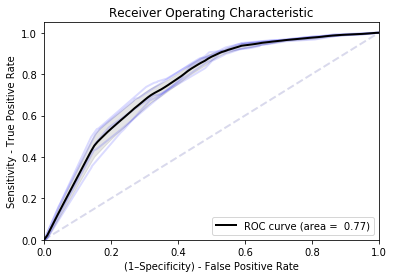

In [17]:
# Create and Save Overall ROC Plot

path = Path('../mydata/myoutput')
img_filename = f'DT_dengue_subgroup_analysis_{splits}_fold_ROC.png'

lw = 2
plt.figure()
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', alpha=0.15)
# plt.axes().set_aspect('equal', 'datalim')

for model_indx in range(len(dfs)):
    fpr = fprs[model_indx]
    tpr = tprs[model_indx]
    plt.plot(fpr, tpr, color='blue',lw=lw, alpha=0.14)

    
# THE MEAN COULD NOT BE CALCULATED AS EACH TPR HAS A DIFFERENT SHAPE
    
mean_tprs = np.array(tprs_interp).mean(axis=0)
std = np.array(tprs_interp).std(axis=0)

tprs_upper = np.minimum(mean_tprs + std, 1)
tprs_lower = mean_tprs - std

plt.plot(base_fpr, mean_tprs, 'black', lw=2,label=f'ROC curve (area = {roc_auc: 0.2f})')
plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.2)


plt.xlabel('(1–Specificity) - False Positive Rate')
plt.ylabel('Sensitivity - True Positive Rate')
plt.title(f'Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

# save file
plt.savefig(path/img_filename, bbox_inches='tight')

plt.show()

## Subgroup Analysis

In [18]:
# Performs subgroup analysis for each model at given sensitivities (recalls)
# Then calculates overall metrics for each subgroup

# recalls defined in Parameters section

# For each recall, 
#     for each model's validation set
#         get confusion matrix of subgroups
#     sum confusion matrices across models for each subgroup
#     calculate metrics from summed confusion matrices
#     store metrics into a dataframe
#     write to csv file


for rec in recalls:    
    confs = 0
    for model_indx in range(len(dfs)):
        dataframes = dfs[model_indx] # subgroups for each model
        Y_pred = model_preds[model_indx]
        valid_Y = model_valid_Ys[model_indx] 
        clf = model_classifiers[model_indx]
        valid_df = subsets[model_indx]

        analysis = subgroup_analysis(clf=clf, dfs=dataframes+[valid_df], dfs_names=dfs_names+['valid_df (overall)'], dep_var='lab_result',recalls=[rec])
#         # Note: first index of analysis is recall value index
#         # second index of analysis is 0 for recall value, 1 for data corresponding to that recall

#         # Example:
#         # if recalls = [0.85,0.90,0.95]
#         # then, analysis[0][0] returns 0.85
#         # analysis[0][1] is the results for recall = 0.85, in dataframe format
#         # analysis[1][0] returns 0.90, analysis[1][1] returns results for recall=0.90, and so forth


        # Sum confusion matrices across models and store roc_auc
        rocs = analysis[0][1]['roc_auc'].values
        confs += analysis[0][1].to_numpy()[:,-4:]

        
    # Calculate Overall Metrics for Each Subgroup
    
    rocs = rocs.tolist()
    confs = confs.tolist()

    names = dfs_names+['valid_df (overall)']
    cols = ['dataframe', 'roc_auc', 'PPV', 'NPV', 'F1', 'accuracy', 'sensitivity', 'specificity', 'odds_ratio', 'TN', 'FP', 'FN', 'TP', 'size']

    results = []
    for i in range(len(names)):
        conf = [confs[i][0],confs[i][1],confs[i][2],confs[i][3]]
        res = pyfiles.autometrics.calc_metrics(confs[i][0],confs[i][1],confs[i][2],confs[i][3], rocs[i])
        results += [[names[i]] + res]

    final_subgroup_results = pd.DataFrame(results,columns=cols)

    to_file = f'DT_dengue_subgroup_analysis_{splits}_fold_recall_{rec:0.2f}.csv'
    path = Path('../mydata/myoutput')

    final_subgroup_results.to_csv(path/to_file, index=None)


/home/gilbert/mystuff/mynbs/pyfiles/autometrics.py:74: RuntimeWarning: divide by zero encountered in long_scalars
  odds_ratio = (TP * TN) /(FP * FN)
/home/gilbert/mystuff/mynbs/pyfiles/autometrics.py:69: RuntimeWarning: invalid value encountered in long_scalars
  NPV = TN / (TN + FN) # negative predict value
/home/gilbert/mystuff/mynbs/pyfiles/autometrics.py:74: RuntimeWarning: invalid value encountered in long_scalars
  odds_ratio = (TP * TN) /(FP * FN)
/home/gilbert/mystuff/mynbs/pyfiles/autometrics.py:74: RuntimeWarning: divide by zero encountered in long_scalars
  odds_ratio = (TP * TN) /(FP * FN)
/home/gilbert/mystuff/mynbs/pyfiles/autometrics.py:74: RuntimeWarning: divide by zero encountered in long_scalars
  odds_ratio = (TP * TN) /(FP * FN)
/home/gilbert/mystuff/mynbs/pyfiles/autometrics.py:69: RuntimeWarning: invalid value encountered in long_scalars
  NPV = TN / (TN + FN) # negative predict value
/home/gilbert/mystuff/mynbs/pyfiles/autometrics.py:74: RuntimeWarning: invalid 

## Results

#### Metrics

In [19]:
path = Path('../mydata/myoutput')

In [20]:
rec = 0.85

x = f'{rec} not in Recalls: {recalls}'
if rec in recalls:
    filename = f'DT_dengue_subgroup_analysis_{splits}_fold_recall_{rec:0.2f}.csv'

    x = pd.read_csv(path/filename)
x

dataframe   roc_auc       PPV       NPV        F1  accuracy  \
0       df_age_under_18  0.743222  0.598456  0.877778  0.711009  0.712984   
1       df_age_18_to_65  0.788066  0.640811  0.800417  0.730281  0.698887   
2     df_age_over_eq_65  0.725048  0.664948  0.702273  0.748188  0.675187   
3             df_female  0.759885  0.630010  0.792531  0.729279  0.682060   
4               df_male  0.786724  0.657570  0.794823  0.743956  0.705528   
5             df_wks_35  0.717743  0.562408  0.741697  0.675485  0.613445   
6       df_wks_35_to_40  0.790406  0.695218  0.770869  0.769443  0.720034   
7        df_wks_over_40  0.739007  0.547461  0.838710  0.664879  0.658470   
8       df_temp_over_38  0.751284  0.726549  0.713998  0.784520  0.722717   
9   df_temp_under_eq_38  0.700608  0.515698  0.836595  0.639510  0.635303   
10           df_wbc_low  0.591794  0.589404  0.508108  0.697583  0.575619   
11        df_wbc_normal  0.748367  0.672456  0.734062  0.758175  0.689464   
12          df_wbc_high  0.662937  0.163097  0.933333  0.272727  0.417861   
13           df_plt_low  0.593526  0.532811  0.559585  0.659394  0.537068   
14          df_plt_high  0.795212  0.681087  0.822123  0.761673  0.734156   
15     df_heart_disease  0.689165  0.647982  0.777778  0.740077  0.689127   
16               df_cva  0.793627  0.645000  0.818966  0.737143  0.708861   
17               df_ckd  0.724000  0.629797  0.776786  0.722798  0.679160   
18             df_liver  0.725806  0.563131  0.769231  0.684049  0.617811   
19                df_dm  0.788860  0.655807  0.786517  0.743775  0.699623   
20      df_hypertension  0.800332  0.651102  0.770053  0.738779  0.689956   
21            df_cancer  0.826284  0.653451  0.778894  0.733114  0.699722   
22                df_er  0.789142  0.677513  0.773723  0.753899  0.710826   
23   valid_df (overall)  0.771968  0.644949  0.790663  0.736023  0.694412   

    sensitivity  specificity  odds_ratio    TN    FP   FN    TP  size  
0      0.875706     0.603053   10.703671   158   104   22   155   439  
1      0.848788     0.560370    7.154861  1151   903  287  1611  3952  
2      0.855249     0.442060    4.681268   309   390  131   774  1604  
3      0.865682     0.502301    6.504597   764   757  200  1289  3010  
4      0.856472     0.554886    7.438922   829   665  214  1277  2985  
5      0.845475     0.402806    3.690460   201   298   70   383   952  
6      0.861412     0.552503    7.674120   905   733  269  1672  3579  
7      0.846416     0.533030    6.290732   468   410   90   496  1464  
8      0.852544     0.534288    6.633039   709   618  284  1642  3253  
9      0.841556     0.506517    5.451654   855   833  167   887  2742  
10     0.854400     0.201717    1.482808    94   372   91   534  1091  
11     0.868941     0.460835    5.666904   806   943  292  1936  3977  
12     0.831933     0.355330    2.728346   280   508   20    99   907  
13     0.864865     0.184615    1.449057   108   477   85   544  1214  
14     0.863888     0.608642    9.870692  1479   951  320  2031  4781  
15     0.862687     0.506289    6.442675   161   157   46   289   653  
16     0.860000     0.572289    8.219316    95    71   21   129   316  
17     0.848024     0.514793    5.920244   348   328  100   558  1334  
18     0.871094     0.388693    4.296724   110   173   33   223   539  
19     0.858998     0.535373    7.019710   280   243   76   463  1062  
20     0.853741     0.517056    6.249503   288   269   86   502  1145  
21     0.834897     0.567766    6.642431   310   236   88   445  1079  
22     0.849697     0.559613    7.183720  1272  1001  372  2103  4748  
23     0.857047     0.533665    6.860915  1609  1406  426  2554  5995

In [21]:
rec = 0.9

x = f'{rec} not in Recalls: {recalls}'
if rec in recalls:
    filename = f'DT_dengue_subgroup_analysis_{splits}_fold_recall_{rec:0.2f}.csv'

    x = pd.read_csv(path/filename)
x

dataframe   roc_auc       PPV       NPV        F1  accuracy  \
0       df_age_under_18  0.743222  0.549488  0.890411  0.685106  0.662870   
1       df_age_18_to_65  0.788066  0.623907  0.846026  0.737613  0.691802   
2     df_age_over_eq_65  0.725048  0.645719  0.749245  0.754821  0.667082   
3             df_female  0.759885  0.624127  0.827346  0.737074  0.682392   
4               df_male  0.786724  0.638005  0.831818  0.746941  0.695142   
5             df_wks_35  0.717743  0.553306  0.796209  0.686767  0.607143   
6       df_wks_35_to_40  0.790406  0.685737  0.814021  0.778990  0.722548   
7        df_wks_over_40  0.739007  0.521696  0.873333  0.661250  0.629781   
8       df_temp_over_38  0.751284  0.712691  0.757794  0.793556  0.724255   
9   df_temp_under_eq_38  0.700608  0.500000  0.870327  0.641497  0.615609   
10           df_wbc_low  0.591794  0.582840  0.558442  0.721171  0.581118   
11        df_wbc_normal  0.748367  0.662238  0.757764  0.761214  0.685441   
12          df_wbc_high  0.662937  0.139334  0.937500  0.243011  0.223815   
13           df_plt_low  0.593526  0.533088  0.611111  0.675597  0.541186   
14          df_plt_high  0.795212  0.660614  0.848141  0.761046  0.722861   
15     df_heart_disease  0.689165  0.640426  0.814208  0.747826  0.689127   
16               df_cva  0.793627  0.609865  0.849462  0.729223  0.680380   
17               df_ckd  0.724000  0.607582  0.818436  0.725826  0.664168   
18             df_liver  0.725806  0.554502  0.811966  0.690265  0.610390   
19                df_dm  0.788860  0.638522  0.819079  0.746338  0.690207   
20      df_hypertension  0.800332  0.633333  0.816393  0.745098  0.682096   
21            df_cancer  0.826284  0.640106  0.843558  0.749611  0.701576   
22                df_er  0.789142  0.667266  0.823654  0.766133  0.713774   
23   valid_df (overall)  0.771968  0.632149  0.831615  0.743118  0.690242   

    sensitivity  specificity  odds_ratio    TN    FP   FN    TP  size  
0      0.909605     0.496183    9.910038   130   132   16   161   439  
1      0.902002     0.497566    9.115112  1022  1032  186  1712  3952  
2      0.908287     0.354793    5.445890   248   451   83   822  1604  
3      0.899933     0.469428    7.956887   714   807  149  1340  3010  
4      0.900738     0.489960    8.717067   732   762  148  1343  2985  
5      0.905077     0.336673    4.839458   168   331   43   410   952  
6      0.901597     0.510379    9.550731   836   802  191  1750  3579  
7      0.902730     0.447608    7.520239   393   485   57   529  1464  
8      0.895119     0.476262    7.761009   632   695  202  1724  3253  
9      0.894687     0.441351    6.711712   745   943  111   943  2742  
10     0.945600     0.092275    1.767000    43   423   34   591  1091  
11     0.894973     0.418525    6.133374   732  1017  234  1994  3977  
12     0.949580     0.114213    2.428367    90   698    6   113   907  
13     0.922099     0.131624    1.794151    77   508   49   580  1214  
14     0.897490     0.553909   10.871293  1346  1084  241  2110  4781  
15     0.898507     0.468553    7.805256   149   169   34   301   653  
16     0.906667     0.475904    8.821018    79    87   14   136   316  
17     0.901216     0.433432    6.979273   293   383   65   593  1334  
18     0.914062     0.335689    5.374758    95   188   22   234   539  
19     0.897959     0.476099    7.997080   249   274   55   484  1062  
20     0.904762     0.447038    7.680195   249   308   56   532  1145  
21     0.904315     0.503663    9.590478   275   271   51   482  1079  
22     0.899394     0.511659    9.366612  1163  1110  249  2226  4748  
23     0.901342     0.481592    8.487237  1452  1563  294  2686  5995

In [22]:
rec = 0.95

x = f'{rec} not in Recalls: {recalls}'
if rec in recalls:
    filename = f'DT_dengue_subgroup_analysis_{splits}_fold_recall_{rec:0.2f}.csv'

    x = pd.read_csv(path/filename)
x

dataframe   roc_auc       PPV       NPV        F1  accuracy  \
0       df_age_under_18  0.743222  0.461749  0.890411  0.622468  0.533030   
1       df_age_18_to_65  0.788066  0.566698  0.888149  0.711512  0.627783   
2     df_age_over_eq_65  0.725048  0.625544  0.809735  0.755147  0.651496   
3             df_female  0.759885  0.589636  0.873582  0.726945  0.647841   
4               df_male  0.786724  0.587190  0.876106  0.726668  0.641876   
5             df_wks_35  0.717743  0.539523  0.851613  0.688000  0.590336   
6       df_wks_35_to_40  0.790406  0.644879  0.866295  0.768430  0.689299   
7        df_wks_over_40  0.739007  0.487292  0.907121  0.643891  0.579918   
8       df_temp_over_38  0.751284  0.697258  0.848485  0.804482  0.726406   
9   df_temp_under_eq_38  0.700608  0.458487  0.895470  0.617008  0.549964   
10           df_wbc_low  0.591794  0.582515  0.561644  0.721850  0.581118   
11        df_wbc_normal  0.748367  0.635160  0.819847  0.760360  0.665577   
12          df_wbc_high  0.662937  0.133714  0.937500  0.235412  0.162073   
13           df_plt_low  0.593526  0.533569  0.695122  0.685974  0.544481   
14          df_plt_high  0.795212  0.591293  0.889001  0.729849  0.653001   
15     df_heart_disease  0.689165  0.599624  0.867769  0.735871  0.649311   
16               df_cva  0.793627  0.557312  0.857143  0.699752  0.617089   
17               df_ckd  0.724000  0.562332  0.858447  0.707276  0.610945   
18             df_liver  0.725806  0.545861  0.869565  0.694168  0.601113   
19                df_dm  0.788860  0.589389  0.856410  0.726885  0.638418   
20      df_hypertension  0.800332  0.596174  0.867647  0.733813  0.644541   
21            df_cancer  0.826284  0.598341  0.880851  0.733479  0.659870   
22                df_er  0.789142  0.634100  0.874644  0.759481  0.687447   
23   valid_df (overall)  0.771968  0.595088  0.882210  0.732180  0.654045   

    sensitivity  specificity  odds_ratio    TN    FP   FN    TP  size  
0      0.954802     0.248092    6.970178    65   197    8   169   439  
1      0.955743     0.324732   10.385021   667  1387   84  1814  3952  
2      0.952486     0.261803    7.109519   183   516   43   862  1604  
3      0.947616     0.354372    9.929096   539   982   78  1411  3010  
4      0.953052     0.331325   10.058559   495   999   70  1421  2985  
5      0.949227     0.264529    6.724322   132   367   23   430   952  
6      0.950541     0.379731   11.765810   622  1016   96  1845  3579  
7      0.948805     0.333713    9.282507   293   585   30   556  1464  
8      0.950675     0.400904   12.897610   532   795   95  1831  3253  
9      0.943074     0.304502    7.253208   514  1174   60   994  2742  
10     0.948800     0.087983    1.787721    41   425   32   593  1091  
11     0.947038     0.307033    7.922680   537  1212  118  2110  3977  
12     0.983193     0.038071    2.315303    30   758    2   117   907  
13     0.960254     0.097436    2.608182    57   528   25   604  1214  
14     0.953211     0.362551   11.587071   881  1549  110  2241  4781  
15     0.952239     0.330189    9.828345   105   213   16   319   653  
16     0.940000     0.325301    7.553571    54   112    9   141   316  
17     0.952888     0.278107    7.791909   188   488   31   627  1334  
18     0.953125     0.282686    8.013136    80   203   12   244   539  
19     0.948052     0.319312    8.561096   167   356   28   511  1062  
20     0.954082     0.317774    9.678070   177   380   27   561  1145  
21     0.947467     0.379121   11.012958   207   339   28   505  1079  
22     0.946667     0.405191   12.091531   921  1352  132  2343  4748  
23     0.951342     0.360199   11.007347  1086  1929  145  2835  5995

#### ROC Curve

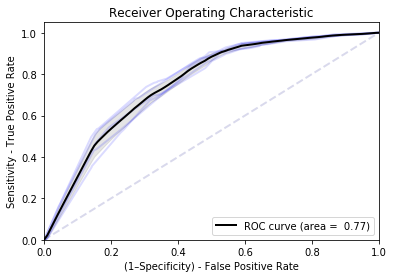

In [23]:
from PIL import Image
img_filename = f'DT_dengue_subgroup_analysis_{splits}_fold_ROC.png'

Image.open(path/img_filename)

&nbsp;


Model 1


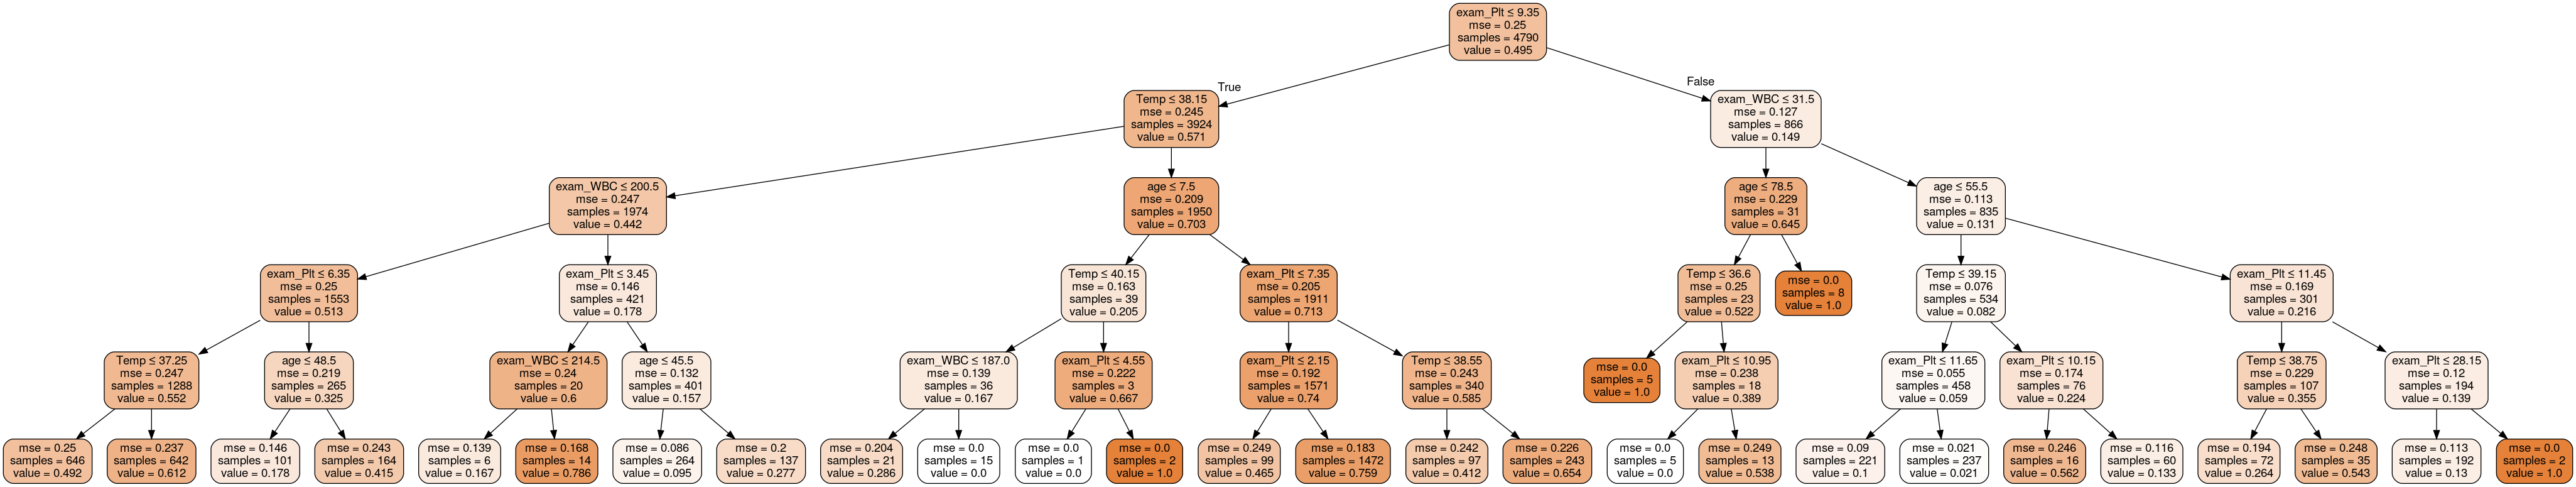



Model 2


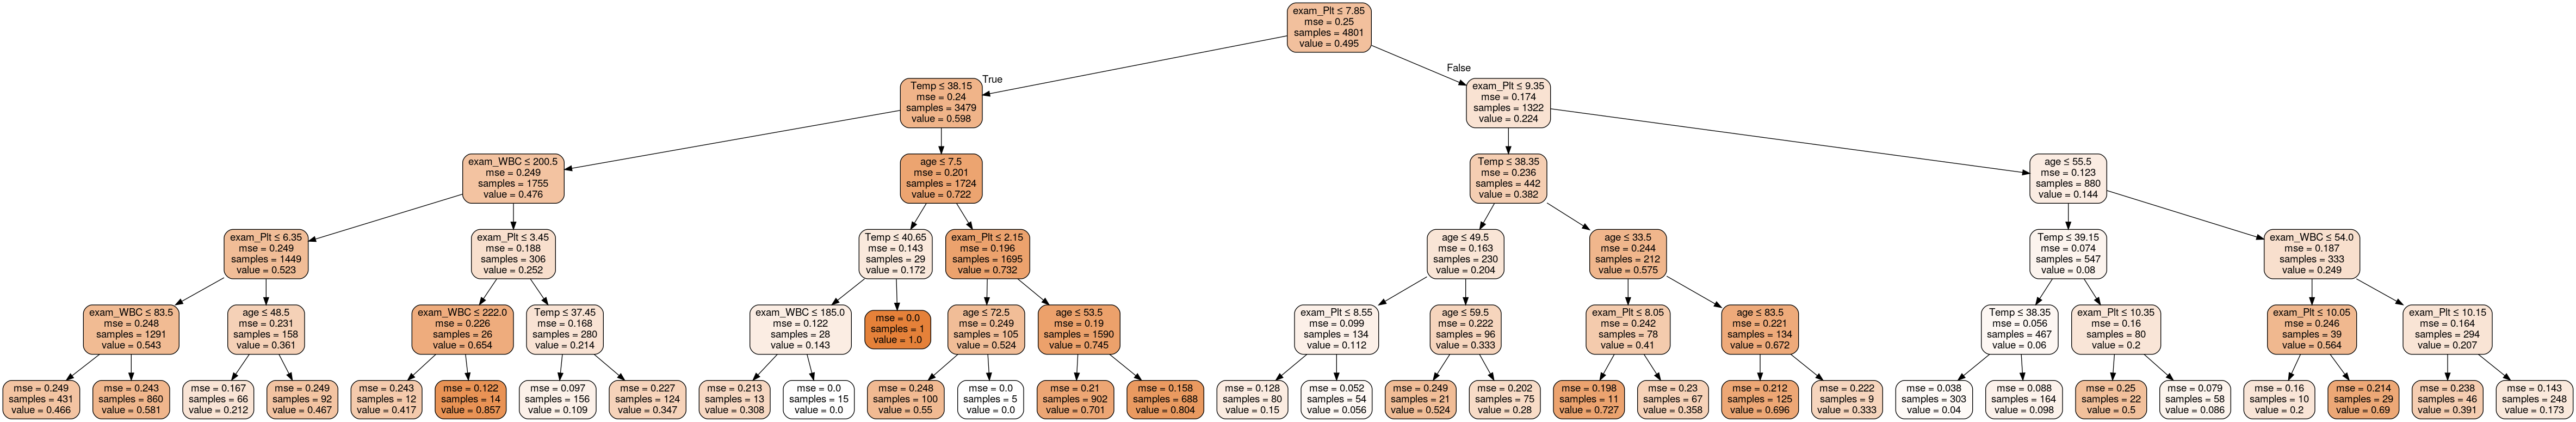



Model 3


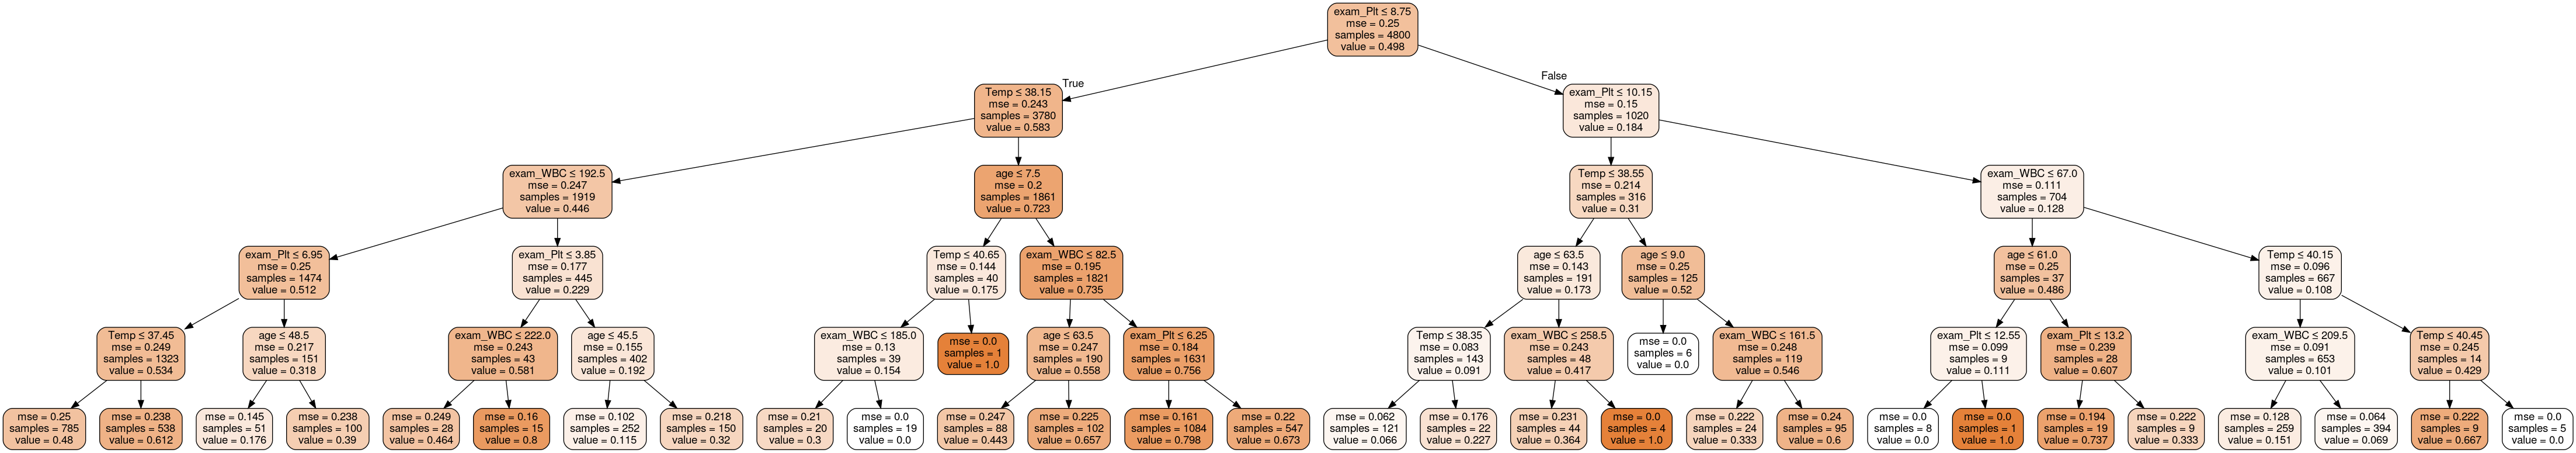



Model 4


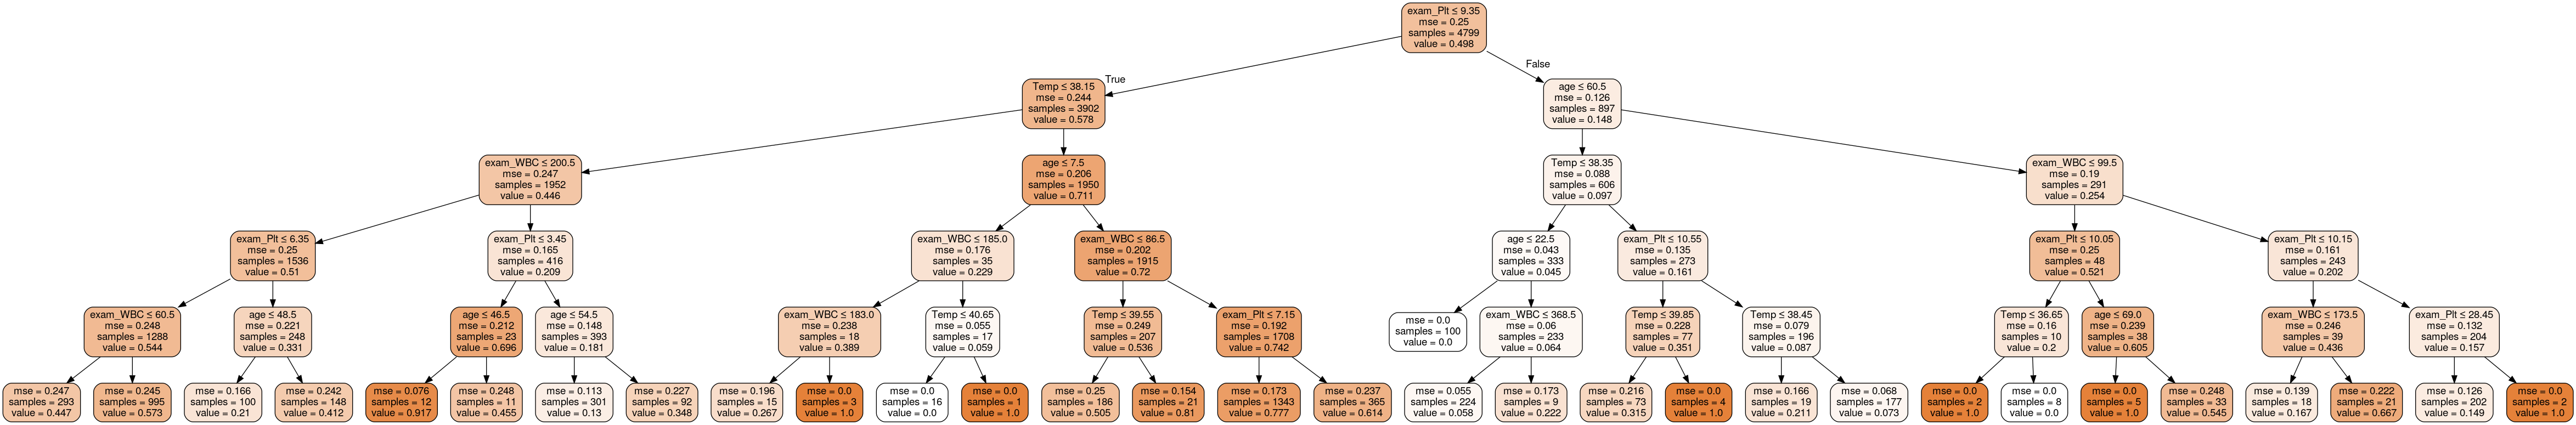



Model 5


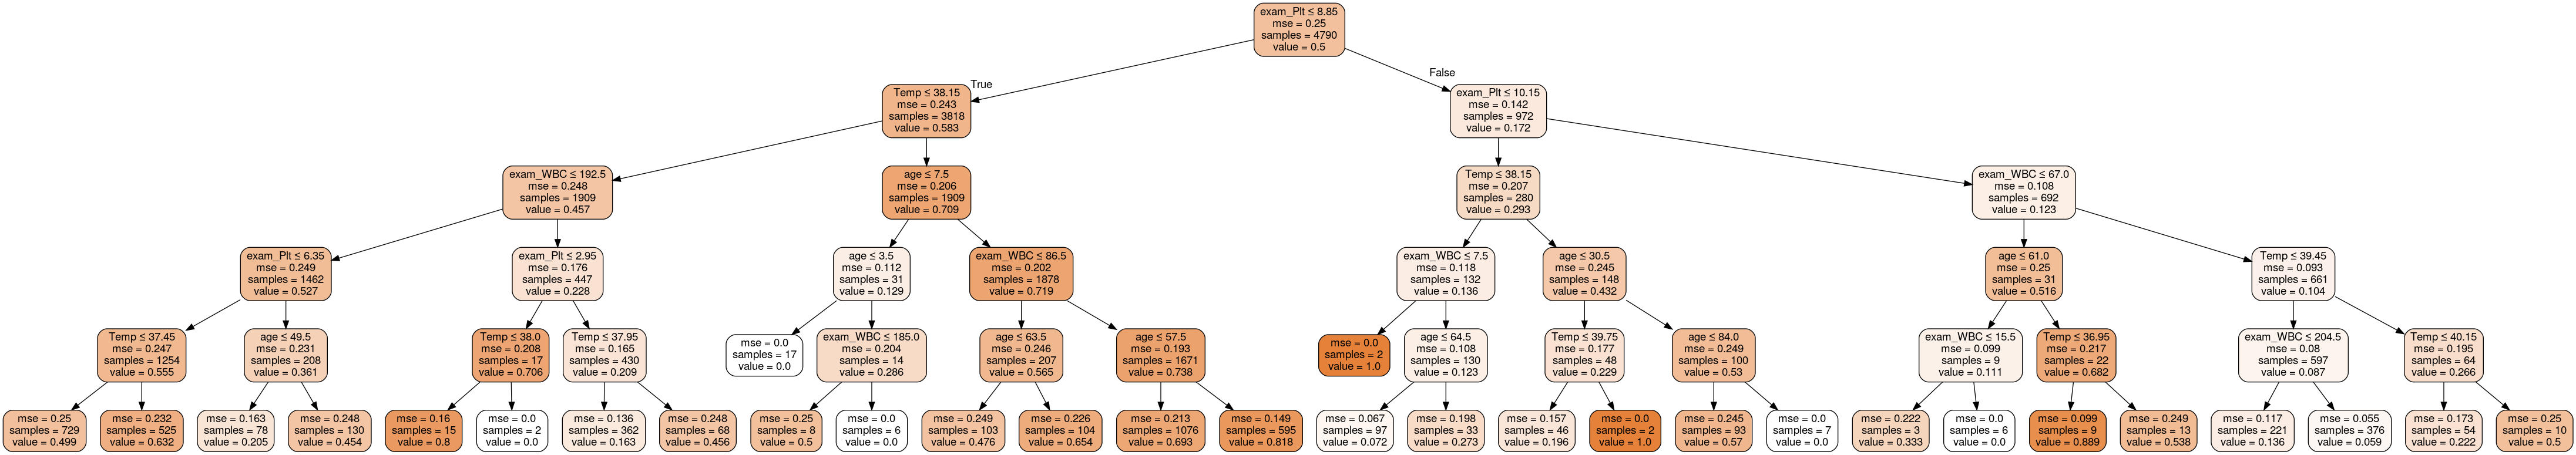

In [24]:
from PIL import Image

for i in range(splits):
    imgfile = f'tree_{i+1}.png'
    img = Image.open(path/imgfile)
    print('\nModel',i+1)
    display(img)
    print('')

&nbsp;

## Conclusion

# &nbsp; 

## (scratchwork)

In [25]:
assert False

AssertionError: 

In [ ]:
type(tprs[0].shape)

In [ ]:
s = min([i.size for i in tprs])
# s = min(s,min([i.size for i in fprs]))
s = 101
tprs = np.array([i[:s] for i in tprs])
fprs = np.array([i[:s] for i in fprs])

In [ ]:
np.array(tprs).shape

In [ ]:
base_fpr.size

# &nbsp; 